# M115 - Image Analysis and Processing, Assignment 2 (Notebook 1)

In this assignment, an intelligent system was developed to detect pneumonia in chest X-ray images, utilising a dataset available at [Kaggle Chest X-Ray Images (Pneumonia) dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). The task involved the creation of two sorts of algorithms; classical Machine Learning and Deep Learning ones. This notebook covers the **Classical ML aspect**, and all the preprocessing thereof. The **Deep Learning** aspect is covered in [Notebook 2](https://github.com/mdarm/Pneumonia-X-Ray-Detection/blob/main/src/deep-learning.ipynb).

---

This notebook is a submission for the Image Analysis and Processing (M115) course, part of the DSIT's Master degree programme at the National and Kapodistrian University of Athens. The coursework was completed during the spring semester of 2023. The author of this project is:

- Michael Darmanis (SID: 7115152200004).

This work incorporates parts of [Hamid Hosen's Notebook](https://www.kaggle.com/code/hosen42/pneumonia-detection-using-traditional-ml).

Please note that this notebook was executed on a Kaggle machine equipped with 30GB of RAM. If you are rerunning this notebook locally or on a different platform such as Google Colab, you may encounter issues due to differences in the computing environment.

Before running any other code, it is crucial to execute the first four code cells to import all necessary libraries. Failing to do so may result in matplotlib not functioning correctly. 

Lastly, run all cells in the order they appear. Many parts of the analysis depend on results or instances created in previous cells.

---

# Table of Contents
* [Data Exploration](#scrollTo=dataExploration)
* [On-the-spot Attempt](#scrollTo=onTheSpot)
  1. [Pre-processing](#scrollTo=pre1)
  2. [Model fitting](#scrollTo=model1)
  3. [SVM parameter tuning](#scrollTo=tune1)
* [Feature-extraction Attempt](#scrollTo=featExtraction)
  1. [Pre-processing while loading dataset](#scrollTo=pre2)
  2. [Model fitting](#scrollTo=model2)
  3. [Logistic Regression parameter tuning](#scrollTo=tune2)
* [Testing Best Intelligent System](#scrollTo=test)

In [1]:
# Dependencies for rendering text of matplotlib in LaTeX
!sudo apt update -y
!sudo apt install -y cm-super dvipng texlive-latex-extra texlive-latex-recommended

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5002 B]
Get:5 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]
Get:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:7 http://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [2356 B]
Get:8 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [474 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2529 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1070 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2866 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2670 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-sec

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
from PIL import Image


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, matthews_corrcoef, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import confusion_matrix


from sklearn.utils import shuffle as shf
import pickle
import os
import glob as gb


import cv2
import skimage
from skimage import feature, filters
from tqdm import tqdm

# Consider aesthetics and consistency
plt.rcParams.update({
        "text.usetex": True,
        "font.size": 15,
        'mathtext.default': 'regular',
        'axes.titlesize': 16,
        "axes.labelsize": 16,
        "legend.fontsize": 15,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15,
        'figure.titlesize': 16,
        'figure.figsize': (12, 7),
        'text.latex.preamble': r'\usepackage{amsmath,amssymb}',
        "font.family": "serif",
        "font.serif": "computer modern roman",
        })

In [3]:
def show_random_images():
    path_random_normal = random.choice(train_normal)
    path_random_pneumonia = random.choice(train_pneumonia)
    
    fig = plt.figure(figsize=(10, 10))
    
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(Image.open(path_random_normal).convert("LA"))
    ax1.set_title("Normal X-ray")
    
    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(Image.open(path_random_pneumonia).convert("LA"))
    ax2.set_title("Pneumonia X-ray")

    
def print_metrics(y_pred, y_train, yt_pred, y_test):
    print('Train data metrics:')
    print('Balanced accuracy score: ', balanced_accuracy_score(y_train, y_pred))
    print('F1 score: ', f1_score(y_train, y_pred))
    print('Precison: ', precision_score(y_train, y_pred))
    print('Recall: ', recall_score(y_train, y_pred))
    print('MCC',  matthews_corrcoef(y_train, y_pred))
    print()
    print('Test data metrics:')
    print('Balanced accuracy score: ', balanced_accuracy_score(y_test, yt_pred))
    print('F1 score: ', f1_score(y_test, yt_pred))
    print('Precison: ', precision_score(y_test, yt_pred))
    print('Recall: ', recall_score(y_test, yt_pred))
    print('MCC',  matthews_corrcoef(y_test, yt_pred))


def plot_confusion_matrix(predictions, y_test, title):
    labels = ['Normal', 'Pnuemonia']
    
    cm = confusion_matrix(y_test,predictions)
    cm = pd.DataFrame(cm , index = labels , columns = labels)
    
    plt.figure()
    sns.heatmap(cm, cmap="YlGnBu", linecolor = 'black' , linewidth = 1,
                annot = True, fmt='', xticklabels = labels,
                yticklabels = labels)
    
    plt.title(title, fontsize = 20)
    plt.xlabel('Predicted', fontsize = 15)
    plt.ylabel('Actual', fontsize = 15)
    
    plt.savefig(f'/kaggle/working/{title.replace(" ", "_")}_cm.pdf',
                format='pdf', bbox_inches='tight', dpi=300, transparent=True)
    plt.show()
    
    
def evaluate_classifiers(X_test, y_test):
    # Create a dictionary to store your classifiers
    classifiers = {'Logistic Regression': lg, 'Decision Tree': dtc,
                   'Random Forest': rfc, 'SVM': svm}

    # Initialize an empty dictionary to store the scores for each classifier
    scores = {'Classifier': [], 'F1': [], 'Balanced Accuracy': [], 'Precision': [],
              'MCC': [], 'Recall': []}

    # Iterate over the classifiers
    for clf_name, clf in classifiers.items():
        y_pred = clf.predict(X_test)

        # Calculate scores
        f1 = f1_score(y_test, y_pred, average='weighted') 
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        mcc = matthews_corrcoef(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='weighted')

        # Add scores to the scores dictionary
        scores['Classifier'].append(clf_name)
        scores['F1'].append(f1)
        scores['Balanced Accuracy'].append(balanced_accuracy)
        scores['Precision'].append(precision)
        scores['MCC'].append(mcc)
        scores['Recall'].append(recall)

    return pd.DataFrame(scores)

<a id="scrollTo=dataExploration"></a>
## Data Exploration

Visualise and understand the dataset's properties, including data distribution, class imbalance, and data quality.

In [4]:
train_normal = gb.glob("../input/chest-xray-pneumonia/chest_xray/train/NORMAL/*")
train_pneumonia = gb.glob("../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*")

test_normal = gb.glob("../input/chest-xray-pneumonia/chest_xray/test/NORMAL/*")
test_pneumonia = gb.glob("../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/*")

val_normal = gb.glob("../input/chest-xray-pneumonia/chest_xray/val/NORMAL/*")
val_pneumonia = gb.glob("../input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/*")

In [5]:
print('Train normal:', len(train_normal), '   ', 'Train pneumonia:', len(train_pneumonia))
print('Test normal:', len(test_normal), '     ', 'Test pneumonia:', len(test_pneumonia))
print('Validation normal:', len(val_normal), ' ', 'Validation pneumonia:', len(val_pneumonia))

Train normal: 1341     Train pneumonia: 3875
Test normal: 234       Test pneumonia: 390
Validation normal: 8   Validation pneumonia: 8


First of all, the validation size is insignificant. It will therefore be concatenated with the training data and, should validation data be required, the training data will be randomly split at a 9-1 analogy.

There also exists an imbalance of classes. To mitigate this issue, the `class_weight` parameter will be employed with the value `balanced`, for all ML models used. The `class_weight` argument modifies the loss function during training by assigning a higher penalty for misclassifying the minority class.

In the face of class imbalance, the implementation of metrics that evaluate performance across all classes, also becomes crucial. Therefore the following metrics will be employed throughout:
- Balanced accuracy
- F1 score
- Precision
- Recall
- Matthews correlation coefficient

Balanced Accuracy, which computes the average recall for each class, provides an effective solution for imbalanced datasets due to its indifference towards the majority class. The F1 score, representing the harmonic mean of precision and recall, is also valuable, especially when the positive class bears more significance and a balance between Precision (representing the accuracy of positive predictions) and Recall (indicating the detection rate of all positive instances) is sought.

Additionally, Precision and Recall are key metrics that permit model fine-tuning in specific directions. Precision, the ratio of true positive predictions to the total predicted positives, becomes vital when the reduction of false positives is the goal. Conversely, Recall, the ratio of true positive predictions to all actual positive instances, is pivotal when the maximization of positive instance detection is the objective. The Matthews Correlation Coefficient (MCC), an all-encompassing measure for binary classifications, takes into account both true and false positives and negatives, thereby offering a balanced metric, particularly useful when the classes are of vastly different sizes.

Within the framework of the currect project, these metrics will provide an satisfactory evaluation of the models' performance; permitting necessary adjustments for managing class imbalance.

Next, random images from both train and test sets are checked.

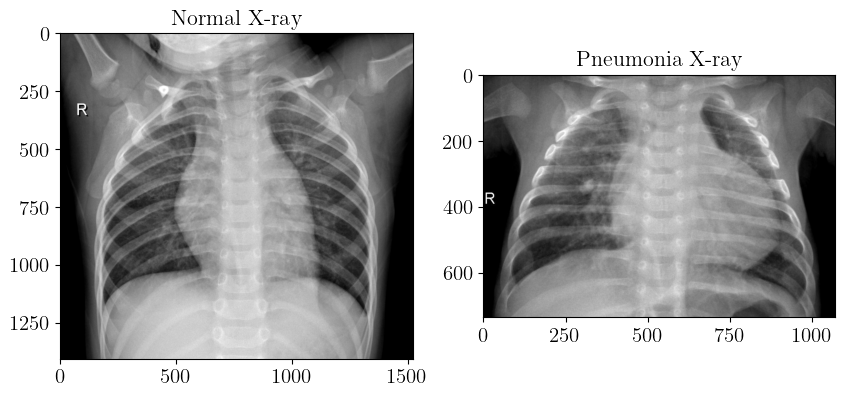

In [6]:
show_random_images()

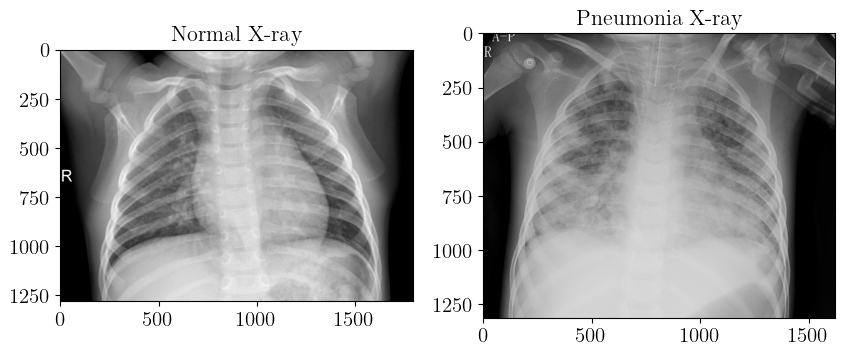

In [7]:
show_random_images()
del train_normal, test_normal, val_normal
del train_pneumonia, test_pneumonia, val_pneumonia

Upon inspection, the images seems to vary in both size and rotation (slightly); this will be born to mind when preprocessing the data and when fitting the ML models.

<a id="scrollTo=onTheSpot"></a>
## On-the-spot attempt

For a first, on-the-spot, attempt; a basic preprocessing will be perfomed. More particularly, the images will be reduced to 300 by 300 pixels and a normalisation & Principal Component Analysis will be applied.

<div style="text-align:center">
<img src="https://i.imgur.com/am9r847.png" alt="workflow" width="500" height="600"/>
</div>

Four classifier models will be trained: Linear Regression, Random Forest, Decision Tree, and a Support Vector Machine. The model yielding the best output in terms of the chosen metrics will then be parameter-tuned using a grid search.

In [8]:
# Assign class of the X-rays based on folder name
code = {'NORMAL':0 ,'PNEUMONIA':1}
def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

In [9]:
# Directories that contain the train and validation images set
paths = ['../input/chest-xray-pneumonia/chest_xray/train/', 
         '../input/chest-xray-pneumonia/chest_xray/val/']

X_train = []
y_train = []

for trainpath in paths:
    for folder in  os.listdir(trainpath) : 
        files = gb.glob(pathname= str( trainpath + folder + '/*.jpeg'))
        for file in files: 
            image = cv2.imread(file)
            # Resize images to 300 x 300 pixels
            image_array = cv2.resize(image , (300, 300))
            X_train.append(list(image_array))
            y_train.append(code[folder])

X_train = np.asarray(X_train)
X_train = X_train.astype(np.float32)
np.save('X_train', X_train)
del X_train

y_train = np.asarray(y_train)
y_train = y_train.astype(np.float32)
np.save('y_train', y_train)
del y_train

In [10]:
# Directory that contains the test images set
testpath='../input/chest-xray-pneumonia/chest_xray/test/'

X_test = []
y_test = []
for folder in  os.listdir(testpath) : 
    files = gb.glob(pathname= str( testpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv2.imread(file)
        # Resize images to 300 x 300 pixels
        image_array = cv2.resize(image , (300, 300))
        X_test.append(list(image_array))
        y_test.append(code[folder])

X_test = np.asarray(X_test)
X_test = X_test.astype(np.float32)
np.save('X_test',X_test)
del X_test

y_test = np.asarray(y_test)
y_test = y_test.astype(np.float32)
np.save('y_test',y_test)
del y_test

In [11]:
# Load datasets
X_train = np.load('./X_train.npy')
X_test = np.load('./X_test.npy')
y_train = np.load('./y_train.npy')
y_test = np.load('./y_test.npy')

In [12]:
# Flatten the images into a 2d array, for model training and testing
X_train = X_train.reshape([-1, np.product((300, 300, 3))])
X_test = X_test.reshape([-1, np.product((300, 300, 3))])

<a id="scrollTo=pre1"></a>
### Pre-processing while loading dataset

In [13]:
# Shuffle train and test datasets in a consistent way
X_train, y_train = shf(X_train, y_train, random_state=15)
X_test, y_test = shf(X_test, y_test, random_state=15)

In [14]:
# Normalise train and test datasets
sc = StandardScaler(copy=False)
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [15]:
# Principal component analysis with 95% retained variance 
pca = PCA(.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

print('Number of components after PCA: ' + str(pca.n_components_))

Number of components after PCA: 658


<a id="scrollTo=model1"></a>
### Model fitting

In [16]:
# Make an instance for each and every classification algorithm
# notice the class_weight option set to balanced
lg  = LogisticRegression(class_weight='balanced')
dtc = DecisionTreeClassifier(class_weight='balanced')
rfc = RandomForestClassifier(class_weight='balanced')
svm = SVC(class_weight='balanced')

In [17]:
# Fitting each vanilla model
lg.fit(X_train, y_train)
dtc.fit(X_train, y_train)
rfc.fit(X_train, y_train)
svm.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC(class_weight='balanced')

In [18]:
# Show evaluation metrics for all algorithms
df_scores = evaluate_classifiers(X_test, y_test)
print(df_scores)

            Classifier        F1  Balanced Accuracy  Precision       MCC  \
0  Logistic Regression  0.762252           0.750000   0.763765  0.495687   
1        Decision Tree  0.731441           0.692308   0.756441  0.448652   
2        Random Forest  0.505044           0.513675   0.722808  0.117698   
3                  SVM  0.818999           0.783333   0.842195  0.634915   

     Recall  
0  0.761218  
1  0.750000  
2  0.634615  
3  0.828526  


Based on all these metrics, it would appear that the SVM model offers the best performance on the unbalanced X-ray dataset. Therefore, a brute-force parameter tuning will be performed based on the F1 score.

<a id="scrollTo=tune1"></a>
### SVM parameter tuning

In [19]:
# Defining parameter range
param_grid_svm = {'C': [0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'linear', 'poly']} 

grid_svm = GridSearchCV(svm, param_grid_svm,
                        refit = True, verbose = 3,
                        scoring='f1')
  
# Fitting the model for grid search on the training data
grid_svm.fit(X_train, y_train)

# Inspect the best parameters found by GridSearchCV
print('Best parameters for SVM:', grid_svm.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.852 total time=   6.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.852 total time=   7.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.000 total time=   6.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.852 total time=   6.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.852 total time=   6.2s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.966 total time=   0.6s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.962 total time=   0.6s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.962 total time=   0.7s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.972 total time=   0.7s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.969 total time=   0.7s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.974 total time=   1.1s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly

In [20]:
# Get the best model
best_svm = grid_svm.best_estimator_

# Calculate and print the metrics
print_metrics(best_svm.predict(X_train), y_train,
              best_svm.predict(X_test), y_test)

Train data metrics:
Balanced accuracy score:  1.0
F1 score:  1.0
Precison:  1.0
Recall:  1.0
MCC 1.0

Test data metrics:
Balanced accuracy score:  0.7350427350427351
F1 score:  0.8558558558558559
Precison:  0.7630522088353414
Recall:  0.9743589743589743
MCC 0.5669139137897514


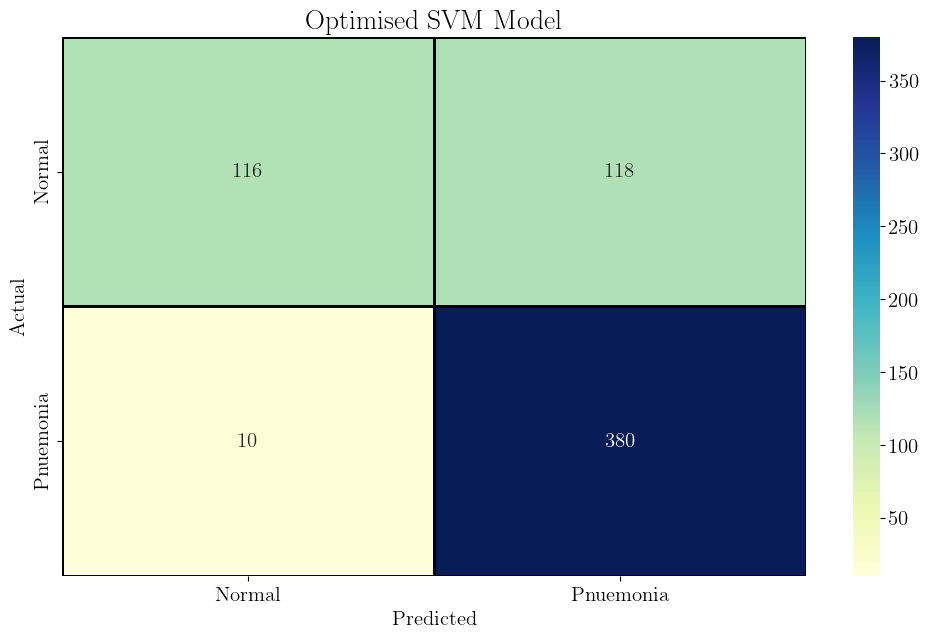

In [21]:
plot_confusion_matrix(best_svm.predict(X_test), y_test, 'Optimised SVM Model')

In [22]:
del X_train, y_train, X_test, y_test, pca, sc

<a id="scrollTo=featExtraction"></a>
## Feature-extraction attempt

As an alternative, and more nuanced approach, traditional image processing methods will be applied. The aim now will be that of extracting features for the classification task.

Pneumonia can readily be observed by lung oppacities, therefore, segmenting and focusing only on the lung part can be of importance (see this [notebook](https://www.kaggle.com/code/mikedarm/what-are-lung-opacities)).

This will be accomplished by using numerous image processing techniques. Here's a brief overview of the steps involved and their importance:

1. **Equalisation**: Image equalisation enhances the contrast of the lungs and accentuates the presence of opacity. This will most likely improve contrast which facilitates subsequent feature extraction.

2. **Image Sharpening**: High pass filtering is used for image sharpening because it reveals more detail compared to the unmask method. Sharpening the image allows for the extraction of more precise and detailed features.

3. **Otsu Thresholding**: Otsu thresholding technique provides smoother edges and better lung segment isolation, which is why it's used in this pipeline.

4. **Edge Detection**: For edge detection, the Sobel filter is chosen as it extracts edges more effectively than the Canny filter in similar [projects](https://doi.org/10.1038/s41551-021-00787-w).

5. **Moment Calculation**: Once the lung segment is identified, the center of the moment is calculated as a feature for prediction. As many X-ray images do not have the same dimensions, this feature can pose a problem however.

6. **Rotation and Scale Invariance**: Some images may present subjects in slightly rotated positions or different sizes. Therefore, the center of the moment is needed to be invariant to rotation and scale. Hu moments are chosen for this purpose ([Digital Image Processing](https://dl.acm.org/doi/book/10.5555/22881)), and to make comparison easier, the moments are logged. The third moment, which depends on the other moments, and the seventh moment, which distinguishes mirror images, are dropped, as no flipped images were observed in the dataset.

The adopted pipeline is seen in the following picture:

<div style="text-align:center">
<img src="https://i.imgur.com/oThquWX.png" alt="workflow" width="500" height="600"/>
</div>

The selected features for building a classifier for pneumonia detection, therefore, are:
* Mean and Standard Deviation of unenhanced image
* Area of opacity
* Perimeter of visible lung regions
* Irregularity index
* Equivalent diameter
* Hu moments (5 out of 7)

The same classifiers will be used as previously, and the best vanilla model will be parameter-tuned.

In [23]:
def area(img):
    # Binarized image as input
    return np.count_nonzero(img)

def perimeter(img):
    # Edges of the image as input
    return np.count_nonzero(img)

def irregularity(area, perimeter):
    # Area and perimeter of the image as input (i.e. compactness)
    I = (4 * np.pi * area) / (perimeter ** 2)
    return I

def equiv_diam(area):
    # Area of image as input
    ed = np.sqrt((4 * area) / np.pi)
    return ed

def get_hu_moments(contour):
    # Hu moments except 3rd and 7th (5 values)
    M = cv2.moments(contour)
    hu = cv2.HuMoments(M).ravel().tolist()
    del hu[2], hu[-1]
    log_hu = [-np.sign(a)*np.log10(np.abs(a)) for a in hu]
    return log_hu

In [24]:
def extract_features(img):
    """
    Feature extraction from an input image.

    This function performs a series of image processing operations and 
    statistical calculations to extract a set of features from the input image. 
    These features can be used for tasks such as image analysis, machine 
    learning, and computer vision.

    Parameters:
    image : ndarray
        The input image from which features are extracted. The image should 
        be in grayscale format.

    Returns:
    list
        A list of extracted features, which includes:

        - mean: The mean pixel intensity of the image.
        - std_dev: The standard deviation of the pixel intensities in the image.
        - area: The area of the largest contour in the binarized image.
        - perimeter: The perimeter of the largest contour in the edge-detected image.
        - irregularity: A measure of the irregularity of the largest contour, 
          calculated as the ratio of the perimeter squared to the area.
        - equiv_diam: The equivalent diameter of the largest contour, calculated 
          as the diameter of a circle with the same area as the contour.
        - hu_moments: Five out of the seven Hu moments of the largest contour, which are 
          invariant to image transformations and can be used for shape analysis.
    """
    mean = img.mean()
    std_dev = img.std()
    
    # Histogram equalisation
    equalized = cv2.equalizeHist(img)
    
    # Sharpening
    hpf_kernel = np.full((3, 3), -1)
    hpf_kernel[1,1] = 9
    sharpened = cv2.filter2D(equalized, -1, hpf_kernel)
    
    # Thresholding
    ret, binarized = cv2.threshold(cv2.GaussianBlur(sharpened, 
                                        (7, 7), 0), 0, 255, 
                                   cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Edge detection
    edges = skimage.filters.sobel(binarized)
    
    # Moments from contours
    contours, hier = cv2.findContours((edges * 255).astype('uint8'), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    select_contour = sorted(contours, key=lambda x: x.shape[0], reverse=True)[0]
    
    # Feature extraction
    ar = area(binarized)
    per = perimeter(edges)
    irreg = irregularity(ar, per)
    eq_diam = equiv_diam(ar)
    hu = get_hu_moments(select_contour)
    
    return [mean, std_dev, ar, per, irreg, eq_diam, *hu]

<a id="scrollTo=pre2"></a>
### Pre-processing

In [25]:
# Directories that contain the train and validation images set
# (class labels are available from previous part)
paths = ['../input/chest-xray-pneumonia/chest_xray/train/', 
         '../input/chest-xray-pneumonia/chest_xray/val/']

X_train = []

for trainpath in paths:
    for folder in  os.listdir(trainpath) : 
        files = gb.glob(pathname= str( trainpath + folder + '/*.jpeg'))
        for file in files: 
            image = cv2.imread(file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            # Feature extraction
            features = extract_features(image)
            X_train.append(features)

X_train = np.asarray(X_train)
X_train = X_train.astype(np.float32)
np.save('X_train_fe', X_train)
del X_train

In [26]:
# Directory that contain the test images set
# (class labels are available from previous part)
testpath='../input/chest-xray-pneumonia/chest_xray/test/'

X_test = []
for folder in  os.listdir(testpath) : 
    files = gb.glob(pathname= str( testpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
        # Feature extraction
        features = extract_features(image)
        X_test.append(features)

X_test = np.asarray(X_test)
X_test = X_test.astype(np.float32)
np.save('X_test_fe',X_test)
del X_test

In [27]:
# Load datasets
X_train = np.load('./X_train_fe.npy')
X_test = np.load('./X_test_fe.npy')
y_train = np.load('./y_train.npy')
y_test = np.load('./y_test.npy')

In [28]:
# Shuffle train and test datasets in a consistent way
X_train, y_train = shf(X_train, y_train, random_state=15)
X_test, y_test = shf(X_test, y_test, random_state=15)

In [29]:
# Normalise datasets
sc = StandardScaler(copy=False)
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

<a id="scrollTo=model2"></a>
### Model fitting

In [30]:
# Fitting each vanilla model
lg.fit(X_train, y_train)
dtc.fit(X_train, y_train)
rfc.fit(X_train, y_train)
svm.fit(X_train, y_train)

SVC(class_weight='balanced')

In [31]:
# Show evaluation metrics for all algorithms
df_scores = evaluate_classifiers(X_test, y_test)
print(df_scores)

            Classifier        F1  Balanced Accuracy  Precision       MCC  \
0  Logistic Regression  0.862054           0.844017   0.863341  0.705754   
1        Decision Tree  0.745347           0.703846   0.790125  0.499225   
2        Random Forest  0.755013           0.711111   0.832206  0.552772   
3                  SVM  0.856109           0.828632   0.866021  0.701196   

     Recall  
0  0.863782  
1  0.767628  
2  0.782051  
3  0.860577  


Considering the above metrics as a whole, Logistic Regression is the best model. However, the difference between Logistic Regression and SVM is quite small. Also the SVM's slightly higher precision might make it a good alternative, especially if avoiding false positives is a priority.

For the time being, the Logistic Regresion will be parameter-tuned.

<a id="scrollTo=tune2"></a>
### Logistic Regression parameter tuning

In [32]:
# Defining parameter range
param_grid_lg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': list(range(100, 800, 100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lg = GridSearchCV(lg, param_grid=param_grid_lg, refit = True,
                       verbose = 3, cv=5, scoring='f1')
  
# Fitting the model for grid search on the training data
grid_lg.fit(X_train, y_train)

# Inspect the best parameters found by GridSearchCV
print('Best parameters for SVM:', grid_lg.best_params_)

Fitting 5 folds for each of 490 candidates, totalling 2450 fits
[CV 1/5] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.001, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.001, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.001, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.001, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 1/5] END C=0.001, max_iter=100, penalty=l2, solver=newton-cg;, score=0.881 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=100, penalty=l2, solver=newton-cg;, score=0.886 total time=   0.1s
[CV 3/5] END C=0.001, max_iter=100, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.1s
[CV 4/5] END C=0.001, max_iter=100, penalty=l2, solver=newton-cg;, score=0.884 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=100, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=100, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=100, penalty=l2, solver=lbfgs;, score=0.886 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=100, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=100, penalty=l2, solver=lbfgs;, score=0.884 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=100, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=100, pena

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 3/5] END C=0.001, max_iter=200, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.1s
[CV 4/5] END C=0.001, max_iter=200, penalty=l2, solver=newton-cg;, score=0.884 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=200, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=200, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=200, penalty=l2, solver=lbfgs;, score=0.886 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=200, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=200, penalty=l2, solver=lbfgs;, score=0.884 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=200, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=200, penalty=l2, solver=liblinear;, score=0.855 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=200, penalty=l2, solver=liblinear;, score=0.863 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=200, pena

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 2/5] END C=0.001, max_iter=300, penalty=l2, solver=newton-cg;, score=0.886 total time=   0.1s
[CV 3/5] END C=0.001, max_iter=300, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.1s
[CV 4/5] END C=0.001, max_iter=300, penalty=l2, solver=newton-cg;, score=0.884 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=300, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.886 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.884 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=300, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=300, penalty=l2, solver=liblinear;, score=0.855 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=300, pena

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 5/5] END C=0.001, max_iter=400, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=400, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=400, penalty=l2, solver=lbfgs;, score=0.886 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=400, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=400, penalty=l2, solver=lbfgs;, score=0.884 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=400, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=400, penalty=l2, solver=liblinear;, score=0.855 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=400, penalty=l2, solver=liblinear;, score=0.863 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=400, penalty=l2, solver=liblinear;, score=0.839 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=400, penalty=l2, solver=liblinear;, score=0.863 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=400, pena

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 3/5] END C=0.001, max_iter=500, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.1s
[CV 4/5] END C=0.001, max_iter=500, penalty=l2, solver=newton-cg;, score=0.884 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=500, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.886 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.884 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=500, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=500, penalty=l2, solver=liblinear;, score=0.855 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=500, penalty=l2, solver=liblinear;, score=0.863 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=500, pena

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 2/5] END C=0.001, max_iter=600, penalty=l2, solver=newton-cg;, score=0.886 total time=   0.1s
[CV 3/5] END C=0.001, max_iter=600, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.1s
[CV 4/5] END C=0.001, max_iter=600, penalty=l2, solver=newton-cg;, score=0.884 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=600, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=600, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=600, penalty=l2, solver=lbfgs;, score=0.886 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=600, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=600, penalty=l2, solver=lbfgs;, score=0.884 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=600, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=600, penalty=l2, solver=liblinear;, score=0.855 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=600, pena

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 3/5] END C=0.001, max_iter=700, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.1s
[CV 4/5] END C=0.001, max_iter=700, penalty=l2, solver=newton-cg;, score=0.884 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=700, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.1s
[CV 1/5] END C=0.001, max_iter=700, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=700, penalty=l2, solver=lbfgs;, score=0.886 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=700, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=700, penalty=l2, solver=lbfgs;, score=0.884 total time=   0.0s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.001, max_iter=700, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=700, penalty=l2, solver=liblinear;, score=0.855 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=700, penalty=l2, solver=liblinear;, score=0.863 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=700, penalty=l2, solver=liblinear;, score=0.839 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=700, penalty=l2, solver=liblinear;, score=0.863 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=700, penalty=l2, solver=liblinear;, score=0.856 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=700, penalty=l2, solver=sag;, score=0.881 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=700, penalty=l2, solver=sag;, score=0.886 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=700, penalty=l2, solver=sag;, score=0.877 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=700, penalty=l2, solver=sag;, score=0.883 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=700, penalty=l2, 

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 5/5] END C=0.01, max_iter=100, penalty=l2, solver=newton-cg;, score=0.881 total time=   0.1s
[CV 1/5] END C=0.01, max_iter=100, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=100, penalty=l2, solver=lbfgs;, score=0.883 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=100, penalty=l2, solver=lbfgs;, score=0.877 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=100, penalty=l2, solver=lbfgs;, score=0.891 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=100, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=100, penalty=l2, solver=liblinear;, score=0.872 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=100, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=100, penalty=l2, solver=liblinear;, score=0.868 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=100, penalty=l2, solver=liblinear;, score=0.886 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=100, penalty=l2, sol

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 2/5] END C=0.01, max_iter=200, penalty=l2, solver=newton-cg;, score=0.883 total time=   0.1s
[CV 3/5] END C=0.01, max_iter=200, penalty=l2, solver=newton-cg;, score=0.877 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=200, penalty=l2, solver=newton-cg;, score=0.891 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=200, penalty=l2, solver=newton-cg;, score=0.881 total time=   0.1s
[CV 1/5] END C=0.01, max_iter=200, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=200, penalty=l2, solver=lbfgs;, score=0.883 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=200, penalty=l2, solver=lbfgs;, score=0.877 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=200, penalty=l2, solver=lbfgs;, score=0.891 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=200, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=200, penalty=l2, solver=liblinear;, score=0.872 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=200, penalty=l2, sol

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 2/5] END C=0.01, max_iter=300, penalty=l2, solver=newton-cg;, score=0.883 total time=   0.1s
[CV 3/5] END C=0.01, max_iter=300, penalty=l2, solver=newton-cg;, score=0.877 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=300, penalty=l2, solver=newton-cg;, score=0.891 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=300, penalty=l2, solver=newton-cg;, score=0.881 total time=   0.1s
[CV 1/5] END C=0.01, max_iter=300, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=300, penalty=l2, solver=lbfgs;, score=0.883 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=300, penalty=l2, solver=lbfgs;, score=0.877 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=300, penalty=l2, solver=lbfgs;, score=0.891 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=300, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=300, penalty=l2, solver=liblinear;, score=0.872 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=300, penalty=l2, sol

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 2/5] END C=0.01, max_iter=400, penalty=l2, solver=newton-cg;, score=0.883 total time=   0.1s
[CV 3/5] END C=0.01, max_iter=400, penalty=l2, solver=newton-cg;, score=0.877 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=400, penalty=l2, solver=newton-cg;, score=0.891 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=400, penalty=l2, solver=newton-cg;, score=0.881 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=400, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=400, penalty=l2, solver=lbfgs;, score=0.883 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=400, penalty=l2, solver=lbfgs;, score=0.877 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=400, penalty=l2, solver=lbfgs;, score=0.891 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=400, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=400, penalty=l2, solver=liblinear;, score=0.872 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=400, penalty=l2, sol

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 2/5] END C=0.01, max_iter=500, penalty=l2, solver=newton-cg;, score=0.883 total time=   0.1s
[CV 3/5] END C=0.01, max_iter=500, penalty=l2, solver=newton-cg;, score=0.877 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=500, penalty=l2, solver=newton-cg;, score=0.891 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=500, penalty=l2, solver=newton-cg;, score=0.881 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=500, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=500, penalty=l2, solver=lbfgs;, score=0.883 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=500, penalty=l2, solver=lbfgs;, score=0.877 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=500, penalty=l2, solver=lbfgs;, score=0.891 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=500, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=500, penalty=l2, solver=liblinear;, score=0.872 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=500, penalty=l2, sol

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 2/5] END C=0.01, max_iter=600, penalty=l2, solver=newton-cg;, score=0.883 total time=   0.1s
[CV 3/5] END C=0.01, max_iter=600, penalty=l2, solver=newton-cg;, score=0.877 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=600, penalty=l2, solver=newton-cg;, score=0.891 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=600, penalty=l2, solver=newton-cg;, score=0.881 total time=   0.1s
[CV 1/5] END C=0.01, max_iter=600, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=600, penalty=l2, solver=lbfgs;, score=0.883 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=600, penalty=l2, solver=lbfgs;, score=0.877 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=600, penalty=l2, solver=lbfgs;, score=0.891 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=600, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=600, penalty=l2, solver=liblinear;, score=0.872 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=600, penalty=l2, sol

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 2/5] END C=0.01, max_iter=700, penalty=l2, solver=newton-cg;, score=0.883 total time=   0.1s
[CV 3/5] END C=0.01, max_iter=700, penalty=l2, solver=newton-cg;, score=0.877 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=700, penalty=l2, solver=newton-cg;, score=0.891 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=700, penalty=l2, solver=newton-cg;, score=0.881 total time=   0.1s
[CV 1/5] END C=0.01, max_iter=700, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=700, penalty=l2, solver=lbfgs;, score=0.883 total time=   0.0s
[CV 3/5] END C=0.01, max_iter=700, penalty=l2, solver=lbfgs;, score=0.877 total time=   0.0s
[CV 4/5] END C=0.01, max_iter=700, penalty=l2, solver=lbfgs;, score=0.891 total time=   0.0s
[CV 5/5] END C=0.01, max_iter=700, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 1/5] END C=0.01, max_iter=700, penalty=l2, solver=liblinear;, score=0.872 total time=   0.0s
[CV 2/5] END C=0.01, max_iter=700, penalty=l2, sol

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, max_iter=100, penalty=l1, solver=saga;, score=0.879 total time=   0.1s
[CV 2/5] END C=0.1, max_iter=100, penalty=l1, solver=saga;, score=0.886 total time=   0.1s
[CV 3/5] END C=0.1, max_iter=100, penalty=l1, solver=saga;, score=0.879 total time=   0.1s
[CV 4/5] END C=0.1, max_iter=100, penalty=l1, solver=saga;, score=0.887 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, max_iter=100, penalty=l1, solver=saga;, score=0.884 total time=   0.1s
[CV 1/5] END C=0.1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 2/5] END C=0.1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.882 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 4/5] END C=0.1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.888 total time=   0.1s
[CV 5/5] END C=0.1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.884 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.888 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.884 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.882 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=100, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=100, penalty=l2, solver=libline

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.1, max_iter=100, penalty=l2, solver=sag;, score=0.882 total time=   0.1s
[CV 3/5] END C=0.1, max_iter=100, penalty=l2, solver=sag;, score=0.878 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=100, penalty=l2, solver=sag;, score=0.888 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, max_iter=100, penalty=l2, solver=sag;, score=0.884 total time=   0.1s
[CV 1/5] END C=0.1, max_iter=100, penalty=l2, solver=saga;, score=0.879 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.1, max_iter=100, penalty=l2, solver=saga;, score=0.882 total time=   0.1s
[CV 3/5] END C=0.1, max_iter=100, penalty=l2, solver=saga;, score=0.878 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, max_iter=100, penalty=l2, solver=saga;, score=0.888 total time=   0.1s
[CV 5/5] END C=0.1, max_iter=100, penalty=l2, solver=saga;, score=0.884 total time=   0.1s
[CV 1/5] END C=0.1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total t

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 4/5] END C=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.888 total time=   0.1s
[CV 5/5] END C=0.1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.884 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.888 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.884 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=200, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=200, penalty=l2, solver=liblinear;, score=0.882 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=200, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=200, penalty=l2, solver=libline

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=0.1, max_iter=200, penalty=l2, solver=saga;, score=0.879 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=0.1, max_iter=200, penalty=l2, solver=saga;, score=0.882 total time=   0.2s
[CV 3/5] END C=0.1, max_iter=200, penalty=l2, solver=saga;, score=0.878 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=0.1, max_iter=200, penalty=l2, solver=saga;, score=0.888 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=0.1, max_iter=200, penalty=l2, solver=saga;, score=0.884 total time=   0.2s
[CV 1/5] END C=0.1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total ti

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 4/5] END C=0.1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.888 total time=   0.1s
[CV 5/5] END C=0.1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.884 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.888 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.884 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=300, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=300, penalty=l2, solver=liblinear;, score=0.882 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=300, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=300, penalty=l2, solver=libline

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 4/5] END C=0.1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.888 total time=   0.1s
[CV 5/5] END C=0.1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.884 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.888 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.884 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=400, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=400, penalty=l2, solver=liblinear;, score=0.882 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=400, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=400, penalty=l2, solver=libline

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 4/5] END C=0.1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.888 total time=   0.1s
[CV 5/5] END C=0.1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.884 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.888 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.884 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=500, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=500, penalty=l2, solver=liblinear;, score=0.882 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=500, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=500, penalty=l2, solver=libline

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 4/5] END C=0.1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.888 total time=   0.1s
[CV 5/5] END C=0.1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.884 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.888 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.884 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=600, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=600, penalty=l2, solver=liblinear;, score=0.882 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=600, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=600, penalty=l2, solver=libline

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 4/5] END C=0.1, max_iter=700, penalty=l2, solver=newton-cg;, score=0.888 total time=   0.1s
[CV 5/5] END C=0.1, max_iter=700, penalty=l2, solver=newton-cg;, score=0.884 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.882 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.888 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.884 total time=   0.0s
[CV 1/5] END C=0.1, max_iter=700, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=700, penalty=l2, solver=liblinear;, score=0.882 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=700, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=700, penalty=l2, solver=libline

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, max_iter=100, penalty=l1, solver=saga;, score=0.880 total time=   0.1s
[CV 2/5] END C=1, max_iter=100, penalty=l1, solver=saga;, score=0.883 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1, max_iter=100, penalty=l1, solver=saga;, score=0.878 total time=   0.1s
[CV 4/5] END C=1, max_iter=100, penalty=l1, solver=saga;, score=0.887 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1, max_iter=100, penalty=l1, solver=saga;, score=0.882 total time=   0.2s
[CV 1/5] END C=1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 2/5] END C=1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.881 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 3/5] END C=1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 4/5] END C=1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.886 total time=   0.1s
[CV 5/5] END C=1, max_iter=100, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.1s
[CV 1/5] END C=1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 3/5] END C=1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 4/5] END C=1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.886 total time=   0.0s
[CV 5/5] END C=1, max_iter=100, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=1, max_iter=100, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=100, penalty=l2, solver=liblinear;, score=0.881 total time=   0.0s
[CV 3/5] END C=1, max_iter=100, penalty=l2, solver=liblinear;, score=0.879 total

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, max_iter=100, penalty=l2, solver=sag;, score=0.879 total time=   0.1s
[CV 2/5] END C=1, max_iter=100, penalty=l2, solver=sag;, score=0.883 total time=   0.1s
[CV 3/5] END C=1, max_iter=100, penalty=l2, solver=sag;, score=0.879 total time=   0.1s
[CV 4/5] END C=1, max_iter=100, penalty=l2, solver=sag;, score=0.884 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, max_iter=100, penalty=l2, solver=sag;, score=0.878 total time=   0.1s
[CV 1/5] END C=1, max_iter=100, penalty=l2, solver=saga;, score=0.882 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=100, penalty=l2, solver=saga;, score=0.884 total time=   0.1s
[CV 3/5] END C=1, max_iter=100, penalty=l2, solver=saga;, score=0.879 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=100, penalty=l2, solver=saga;, score=0.886 total time=   0.1s
[CV 5/5] END C=1, max_iter=100, penalty=l2, solver=saga;, score=0.881 total time=   0.1s
[CV 1/5] END C=1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] E

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, max_iter=200, penalty=l1, solver=liblinear;, score=0.879 total time=   0.1s
[CV 2/5] END C=1, max_iter=200, penalty=l1, solver=liblinear;, score=0.880 total time=   0.1s
[CV 3/5] END C=1, max_iter=200, penalty=l1, solver=liblinear;, score=0.877 total time=   0.1s
[CV 4/5] END C=1, max_iter=200, penalty=l1, solver=liblinear;, score=0.886 total time=   0.1s
[CV 5/5] END C=1, max_iter=200, penalty=l1, solver=liblinear;, score=0.878 total time=   0.1s
[CV 1/5] END C=1, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=200, penalty=l1, solver=sag;, score=nan total time=   0.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, max_iter=200, penalty=l1, solver=saga;, score=0.879 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=200, penalty=l1, solver=saga;, score=0.883 total time=   0.2s
[CV 3/5] END C=1, max_iter=200, penalty=l1, solver=saga;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=200, penalty=l1, solver=saga;, score=0.886 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1, max_iter=200, penalty=l1, solver=saga;, score=0.879 total time=   0.2s
[CV 1/5] END C=1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.881 total time=   0.1s
[CV 3/5] END C=1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 4/5] END C=1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.886 total time=   0.1s
[CV 5/5] END C=1, max_iter=200, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 3/5] END C=1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 4/5] END C=1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.886 total time=   0.0s
[CV 5/5] END C=1, max_iter=200, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=1, max_iter=200, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=200, penalty=l2, solver=liblinear;, score=0.881 total time=   0.0s
[CV 3/5] END C=1, max_iter=200, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 4/5] END C=1, max_iter=200, penalty=l2, solver=liblinear;, score=0.886 total

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, max_iter=200, penalty=l2, solver=sag;, score=0.879 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=200, penalty=l2, solver=sag;, score=0.882 total time=   0.2s
[CV 3/5] END C=1, max_iter=200, penalty=l2, solver=sag;, score=0.879 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=200, penalty=l2, solver=sag;, score=0.886 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, max_iter=200, penalty=l2, solver=sag;, score=0.879 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, max_iter=200, penalty=l2, solver=saga;, score=0.879 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=200, penalty=l2, solver=saga;, score=0.883 total time=   0.2s
[CV 3/5] END C=1, max_iter=200, penalty=l2, solver=saga;, score=0.879 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=200, penalty=l2, solver=saga;, score=0.884 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, max_iter=200, penalty=l2, solver=saga;, score=0.878 total time=   0.2s
[CV 1/5] END C=1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] EN

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, max_iter=300, penalty=l1, solver=saga;, score=0.879 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=300, penalty=l1, solver=saga;, score=0.882 total time=   0.4s
[CV 3/5] END C=1, max_iter=300, penalty=l1, solver=saga;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=300, penalty=l1, solver=saga;, score=0.886 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1, max_iter=300, penalty=l1, solver=saga;, score=0.880 total time=   0.4s
[CV 1/5] END C=1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.881 total time=   0.1s
[CV 3/5] END C=1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 4/5] END C=1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.886 total time=   0.1s
[CV 5/5] END C=1, max_iter=300, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 3/5] END C=1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 4/5] END C=1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.886 total time=   0.0s
[CV 5/5] END C=1, max_iter=300, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=1, max_iter=300, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=300, penalty=l2, solver=liblinear;, score=0.881 total time=   0.0s
[CV 3/5] END C=1, max_iter=300, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 4/5] END C=1, max_iter=300, penalty=l2, solver=liblinear;, score=0.886 total

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, max_iter=300, penalty=l2, solver=sag;, score=0.879 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=300, penalty=l2, solver=sag;, score=0.882 total time=   0.3s
[CV 3/5] END C=1, max_iter=300, penalty=l2, solver=sag;, score=0.879 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=300, penalty=l2, solver=sag;, score=0.886 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, max_iter=300, penalty=l2, solver=sag;, score=0.878 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, max_iter=300, penalty=l2, solver=saga;, score=0.879 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=300, penalty=l2, solver=saga;, score=0.883 total time=   0.3s
[CV 3/5] END C=1, max_iter=300, penalty=l2, solver=saga;, score=0.879 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=300, penalty=l2, solver=saga;, score=0.886 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, max_iter=300, penalty=l2, solver=saga;, score=0.879 total time=   0.3s
[CV 1/5] END C=1, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] EN

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, max_iter=400, penalty=l1, solver=saga;, score=0.878 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=400, penalty=l1, solver=saga;, score=0.881 total time=   0.5s
[CV 3/5] END C=1, max_iter=400, penalty=l1, solver=saga;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=400, penalty=l1, solver=saga;, score=0.886 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did n

[CV 5/5] END C=1, max_iter=400, penalty=l1, solver=saga;, score=0.879 total time=   0.5s
[CV 1/5] END C=1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.881 total time=   0.1s
[CV 3/5] END C=1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 4/5] END C=1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.886 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1, max_iter=400, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 3/5] END C=1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 4/5] END C=1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.886 total time=   0.0s
[CV 5/5] END C=1, max_iter=400, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=1, max_iter=400, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=400, penalty=l2, solver=liblinear;, score=0.881 total time=   0.0s
[CV 3/5] END C=1, max_iter=400, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 4/5] END C=1, max_iter=400, penalty=l2, solver=liblinear;, score=0.886 total time=   0.0s
[CV 5/5] END C=1, max_iter=400, penalty=l2, solver=liblinear;, score=0.877 total

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=400, penalty=l2, solver=sag;, score=0.881 total time=   0.4s
[CV 3/5] END C=1, max_iter=400, penalty=l2, solver=sag;, score=0.879 total time=   0.1s
[CV 4/5] END C=1, max_iter=400, penalty=l2, solver=sag;, score=0.886 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, max_iter=400, penalty=l2, solver=sag;, score=0.878 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, max_iter=400, penalty=l2, solver=saga;, score=0.879 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=400, penalty=l2, solver=saga;, score=0.882 total time=   0.4s
[CV 3/5] END C=1, max_iter=400, penalty=l2, solver=saga;, score=0.879 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=400, penalty=l2, solver=saga;, score=0.886 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, max_iter=400, penalty=l2, solver=saga;, score=0.879 total time=   0.4s
[CV 1/5] END C=1, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] EN

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, max_iter=500, penalty=l1, solver=saga;, score=0.878 total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=500, penalty=l1, solver=saga;, score=0.881 total time=   0.6s
[CV 3/5] END C=1, max_iter=500, penalty=l1, solver=saga;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=500, penalty=l1, solver=saga;, score=0.887 total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did n

[CV 5/5] END C=1, max_iter=500, penalty=l1, solver=saga;, score=0.880 total time=   0.6s
[CV 1/5] END C=1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.881 total time=   0.0s
[CV 3/5] END C=1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 4/5] END C=1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.886 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1, max_iter=500, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 3/5] END C=1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 4/5] END C=1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.886 total time=   0.0s
[CV 5/5] END C=1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=1, max_iter=500, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=500, penalty=l2, solver=liblinear;, score=0.881 total time=   0.0s
[CV 3/5] END C=1, max_iter=500, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 4/5] END C=1, max_iter=500, penalty=l2, solver=liblinear;, score=0.886 total time=   0.0s
[CV 5/5] END C=1, max_iter=500, penalty=l2, solver=liblinear;, score=0.877 total

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, max_iter=500, penalty=l2, solver=saga;, score=0.879 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=500, penalty=l2, solver=saga;, score=0.882 total time=   0.5s
[CV 3/5] END C=1, max_iter=500, penalty=l2, solver=saga;, score=0.879 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=500, penalty=l2, solver=saga;, score=0.886 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1, max_iter=500, penalty=l2, solver=saga;, score=0.878 total time=   0.5s
[CV 1/5] END C=1, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] EN

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1, max_iter=600, penalty=l1, solver=saga;, score=0.878 total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=600, penalty=l1, solver=saga;, score=0.881 total time=   0.7s
[CV 3/5] END C=1, max_iter=600, penalty=l1, solver=saga;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1, max_iter=600, penalty=l1, solver=saga;, score=0.887 total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did n

[CV 5/5] END C=1, max_iter=600, penalty=l1, solver=saga;, score=0.881 total time=   0.7s
[CV 1/5] END C=1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.881 total time=   0.0s
[CV 3/5] END C=1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 4/5] END C=1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.886 total time=   0.1s
[CV 5/5] END C=1, max_iter=600, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 3/5] END C=1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 4/5] END C=1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.886 total time=   0.0s
[CV 5/5] END C=1, max_iter=600, penalty=l2, solver=lbfgs;, score=0.878 total time

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 2/5] END C=1, max_iter=600, penalty=l2, solver=liblinear;, score=0.881 total time=   0.0s
[CV 3/5] END C=1, max_iter=600, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 4/5] END C=1, max_iter=600, penalty=l2, solver=liblinear;, score=0.886 total time=   0.0s
[CV 5/5] END C=1, max_iter=600, penalty=l2, solver=liblinear;, score=0.877 total time=   0.0s
[CV 1/5] END C=1, max_iter=600, penalty=l2, solver=sag;, score=0.879 total time=   0.3s
[CV 2/5] END C=1, max_iter=600, penalty=l2, solver=sag;, score=0.881 total time=   0.4s
[CV 3/5] END C=1, max_iter=600, penalty=l2, solver=sag;, score=0.879 total time=   0.1s
[CV 4/5] END C=1, max_iter=600, penalty=l2, solver=sag;, score=0.886 total time=   0.4s
[CV 5/5] END C=1, max_iter=600, penalty=l2, solver=sag;, score=0.878 total time=   0.4s
[CV 1/5] END C=1, max_iter=600, penalty=l2, solver=saga;, score=0.879 total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1, max_iter=600, penalty=l2, solver=saga;, score=0.882 total time=   0.6s
[CV 3/5] END C=1, max_iter=600, penalty=l2, solver=saga;, score=0.879 total time=   0.2s
[CV 4/5] END C=1, max_iter=600, penalty=l2, solver=saga;, score=0.886 total time=   0.5s
[CV 5/5] END C=1, max_iter=600, penalty=l2, solver=saga;, score=0.878 total time=   0.6s
[CV 1/5] END C=1, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5]

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 5/5] END C=1, max_iter=700, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.881 total time=   0.0s
[CV 3/5] END C=1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 4/5] END C=1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.886 total time=   0.0s
[CV 5/5] END C=1, max_iter=700, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=1, max_iter=700, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=1, max_iter=700, penalty=l2, solver=liblinear;, score=0.881 total time=   0.0s
[CV 3/5] END C=1, max_iter=700, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 4/5] END C=1, max_iter=700, penalty=l2, solver=liblinear;, score=0.886 total time=   0.0s
[CV 5/5] END C=1, max_iter=700, penalty=l2, solver=liblinear;, score=0.877 total

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=100, penalty=l1, solver=saga;, score=0.883 total time=   0.1s
[CV 3/5] END C=10, max_iter=100, penalty=l1, solver=saga;, score=0.878 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=100, penalty=l1, solver=saga;, score=0.885 total time=   0.1s
[CV 5/5] END C=10, max_iter=100, penalty=l1, solver=saga;, score=0.882 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 1/5] END C=10, max_iter=100, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 2/5] END C=10, max_iter=100, penalty=l2, solver=newton-cg;, score=0.880 total time=   0.1s
[CV 3/5] END C=10, max_iter=100, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 4/5] END C=10, max_iter=100, penalty=l2, solver=newton-cg;, score=0.887 total time=   0.0s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 5/5] END C=10, max_iter=100, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.880 total time=   0.0s
[CV 3/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 4/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.887 total time=   0.0s
[CV 5/5] END C=10, max_iter=100, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.880 total time=   0.0s
[CV 3/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 4/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=0.887 total time=   0.0s
[CV 5/5] END C=10, max_iter=100, penalty=l2, solver=liblinear;, score=

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=100, penalty=l2, solver=sag;, score=0.883 total time=   0.1s
[CV 3/5] END C=10, max_iter=100, penalty=l2, solver=sag;, score=0.878 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=100, penalty=l2, solver=sag;, score=0.886 total time=   0.1s
[CV 5/5] END C=10, max_iter=100, penalty=l2, solver=sag;, score=0.878 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=100, penalty=l2, solver=saga;, score=0.878 total time=   0.1s
[CV 2/5] END C=10, max_iter=100, penalty=l2, solver=saga;, score=0.883 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=10, max_iter=100, penalty=l2, solver=saga;, score=0.878 total time=   0.1s
[CV 4/5] END C=10, max_iter=100, penalty=l2, solver=saga;, score=0.885 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10, max_iter=100, penalty=l2, solver=saga;, score=0.882 total time=   0.1s
[CV 1/5] END C=10, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=200, penalty=l1, solver=saga;, score=0.879 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=200, penalty=l1, solver=saga;, score=0.883 total time=   0.2s
[CV 3/5] END C=10, max_iter=200, penalty=l1, solver=saga;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=200, penalty=l1, solver=saga;, score=0.886 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did n

[CV 5/5] END C=10, max_iter=200, penalty=l1, solver=saga;, score=0.878 total time=   0.2s
[CV 1/5] END C=10, max_iter=200, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 2/5] END C=10, max_iter=200, penalty=l2, solver=newton-cg;, score=0.880 total time=   0.1s
[CV 3/5] END C=10, max_iter=200, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 4/5] END C=10, max_iter=200, penalty=l2, solver=newton-cg;, score=0.887 total time=   0.1s
[CV 5/5] END C=10, max_iter=200, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=10, max_iter=200, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=10, max_iter=200, penalty=l2, solver=lbfgs;, score=0.880 total time=   0.0s
[CV 3/5] END C=10, max_iter=200, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 4/5] END C=10, max_iter=200, penalty=l2, solver=lbfgs;, score=0.887 total time=   0.0s
[CV 5/5] END C=10, max_iter=200, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=10, max_iter=200, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=10, max_iter=200, penalty=l2, solver=liblinear;, score=0.880 total time=   0.0s
[CV 3/5] END C=10, max_iter=200, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 4/5] END C=10, max_iter=200, penalty=l2, solver=liblinear;, score=

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=200, penalty=l2, solver=sag;, score=0.877 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=200, penalty=l2, solver=sag;, score=0.881 total time=   0.2s
[CV 3/5] END C=10, max_iter=200, penalty=l2, solver=sag;, score=0.878 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=200, penalty=l2, solver=sag;, score=0.886 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10, max_iter=200, penalty=l2, solver=sag;, score=0.877 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=200, penalty=l2, solver=saga;, score=0.879 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=200, penalty=l2, solver=saga;, score=0.883 total time=   0.2s
[CV 3/5] END C=10, max_iter=200, penalty=l2, solver=saga;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=200, penalty=l2, solver=saga;, score=0.886 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10, max_iter=200, penalty=l2, solver=saga;, score=0.878 total time=   0.2s
[CV 1/5] END C=10, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=300, penalty=l1, solver=saga;, score=0.879 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=300, penalty=l1, solver=saga;, score=0.881 total time=   0.4s
[CV 3/5] END C=10, max_iter=300, penalty=l1, solver=saga;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=300, penalty=l1, solver=saga;, score=0.886 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=10, max_iter=300, penalty=l1, solver=saga;, score=0.879 total time=   0.4s
[CV 1/5] END C=10, max_iter=300, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 2/5] END C=10, max_iter=300, penalty=l2, solver=newton-cg;, score=0.880 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 3/5] END C=10, max_iter=300, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.1s
[CV 4/5] END C=10, max_iter=300, penalty=l2, solver=newton-cg;, score=0.887 total time=   0.0s
[CV 5/5] END C=10, max_iter=300, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=10, max_iter=300, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=10, max_iter=300, penalty=l2, solver=lbfgs;, score=0.880 total time=   0.0s
[CV 3/5] END C=10, max_iter=300, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 4/5] END C=10, max_iter=300, penalty=l2, solver=lbfgs;, score=0.887 total time=   0.0s
[CV 5/5] END C=10, max_iter=300, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=10, max_iter=300, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=10, max_iter=300, penalty=l2, solver=liblinear;, score=0.880 total time=   0.0s
[CV 3/5] END C=10, max_iter=300, penalty=l2, solver=liblinear;, score=

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=300, penalty=l2, solver=sag;, score=0.878 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=300, penalty=l2, solver=sag;, score=0.879 total time=   0.3s
[CV 3/5] END C=10, max_iter=300, penalty=l2, solver=sag;, score=0.878 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=300, penalty=l2, solver=sag;, score=0.887 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10, max_iter=300, penalty=l2, solver=sag;, score=0.879 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=300, penalty=l2, solver=saga;, score=0.879 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=300, penalty=l2, solver=saga;, score=0.881 total time=   0.3s
[CV 3/5] END C=10, max_iter=300, penalty=l2, solver=saga;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=300, penalty=l2, solver=saga;, score=0.886 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10, max_iter=300, penalty=l2, solver=saga;, score=0.879 total time=   0.3s
[CV 1/5] END C=10, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=400, penalty=l1, solver=saga;, score=0.877 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=400, penalty=l1, solver=saga;, score=0.881 total time=   0.5s
[CV 3/5] END C=10, max_iter=400, penalty=l1, solver=saga;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=400, penalty=l1, solver=saga;, score=0.886 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=10, max_iter=400, penalty=l1, solver=saga;, score=0.879 total time=   0.5s
[CV 1/5] END C=10, max_iter=400, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 2/5] END C=10, max_iter=400, penalty=l2, solver=newton-cg;, score=0.880 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 3/5] END C=10, max_iter=400, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.1s
[CV 4/5] END C=10, max_iter=400, penalty=l2, solver=newton-cg;, score=0.887 total time=   0.1s
[CV 5/5] END C=10, max_iter=400, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.1s
[CV 1/5] END C=10, max_iter=400, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.1s
[CV 2/5] END C=10, max_iter=400, penalty=l2, solver=lbfgs;, score=0.880 total time=   0.0s
[CV 3/5] END C=10, max_iter=400, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 4/5] END C=10, max_iter=400, penalty=l2, solver=lbfgs;, score=0.887 total time=   0.0s
[CV 5/5] END C=10, max_iter=400, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=10, max_iter=400, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=10, max_iter=400, penalty=l2, solver=liblinear;, score=0.880 total time=   0.0s
[CV 3/5] END C=10, max_iter=400, penalty=l2, solver=liblinear;, score=

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=400, penalty=l2, solver=sag;, score=0.879 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=400, penalty=l2, solver=sag;, score=0.880 total time=   0.4s
[CV 3/5] END C=10, max_iter=400, penalty=l2, solver=sag;, score=0.878 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=400, penalty=l2, solver=sag;, score=0.887 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10, max_iter=400, penalty=l2, solver=sag;, score=0.878 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=400, penalty=l2, solver=saga;, score=0.877 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=400, penalty=l2, solver=saga;, score=0.881 total time=   0.4s
[CV 3/5] END C=10, max_iter=400, penalty=l2, solver=saga;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=400, penalty=l2, solver=saga;, score=0.886 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10, max_iter=400, penalty=l2, solver=saga;, score=0.877 total time=   0.4s
[CV 1/5] END C=10, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=500, penalty=l1, solver=saga;, score=0.878 total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=500, penalty=l1, solver=saga;, score=0.881 total time=   0.6s
[CV 3/5] END C=10, max_iter=500, penalty=l1, solver=saga;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=500, penalty=l1, solver=saga;, score=0.887 total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=10, max_iter=500, penalty=l1, solver=saga;, score=0.879 total time=   0.6s
[CV 1/5] END C=10, max_iter=500, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 2/5] END C=10, max_iter=500, penalty=l2, solver=newton-cg;, score=0.880 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 3/5] END C=10, max_iter=500, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.1s
[CV 4/5] END C=10, max_iter=500, penalty=l2, solver=newton-cg;, score=0.887 total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.880 total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 4/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.887 total time=   0.0s
[CV 5/5] END C=10, max_iter=500, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=10, max_iter=500, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=10, max_iter=500, penalty=l2, solver=liblinear;, score=0.880 total time=   0.0s
[CV 3/5] END C=10, max_iter=500, penalty=l2, solver=liblinear;, score=

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.878 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.881 total time=   0.5s
[CV 3/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.887 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10, max_iter=500, penalty=l2, solver=saga;, score=0.879 total time=   0.5s
[CV 1/5] END C=10, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=10, max_iter=600, penalty=l1, solver=saga;, score=0.879 total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=600, penalty=l1, solver=saga;, score=0.880 total time=   0.7s
[CV 3/5] END C=10, max_iter=600, penalty=l1, solver=saga;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=10, max_iter=600, penalty=l1, solver=saga;, score=0.887 total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=10, max_iter=600, penalty=l1, solver=saga;, score=0.878 total time=   0.7s
[CV 1/5] END C=10, max_iter=600, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 2/5] END C=10, max_iter=600, penalty=l2, solver=newton-cg;, score=0.880 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 3/5] END C=10, max_iter=600, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.1s
[CV 4/5] END C=10, max_iter=600, penalty=l2, solver=newton-cg;, score=0.887 total time=   0.0s
[CV 5/5] END C=10, max_iter=600, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=10, max_iter=600, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=10, max_iter=600, penalty=l2, solver=lbfgs;, score=0.880 total time=   0.0s
[CV 3/5] END C=10, max_iter=600, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 4/5] END C=10, max_iter=600, penalty=l2, solver=lbfgs;, score=0.887 total time=   0.0s
[CV 5/5] END C=10, max_iter=600, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=10, max_iter=600, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=10, max_iter=600, penalty=l2, solver=liblinear;, score=0.880 total time=   0.0s
[CV 3/5] END C=10, max_iter=600, penalty=l2, solver=liblinear;, score=

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=600, penalty=l2, solver=saga;, score=0.879 total time=   0.6s
[CV 3/5] END C=10, max_iter=600, penalty=l2, solver=saga;, score=0.878 total time=   0.2s
[CV 4/5] END C=10, max_iter=600, penalty=l2, solver=saga;, score=0.887 total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10, max_iter=600, penalty=l2, solver=saga;, score=0.879 total time=   0.6s
[CV 1/5] END C=10, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=10, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=10, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=10, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=10, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=10, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 3/5] END C=10, max_iter=700, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 4/5] END C=10, max_iter=700, penalty=l2, solver=newton-cg;, score=0.887 total time=   0.0s
[CV 5/5] END C=10, max_iter=700, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=10, max_iter=700, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=10, max_iter=700, penalty=l2, solver=lbfgs;, score=0.880 total time=   0.0s
[CV 3/5] END C=10, max_iter=700, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 4/5] END C=10, max_iter=700, penalty=l2, solver=lbfgs;, score=0.887 total time=   0.0s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=10, max_iter=700, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=10, max_iter=700, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=10, max_iter=700, penalty=l2, solver=liblinear;, score=0.880 total time=   0.0s
[CV 3/5] END C=10, max_iter=700, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 4/5] END C=10, max_iter=700, penalty=l2, solver=liblinear;, score=0.887 total time=   0.0s
[CV 5/5] END C=10, max_iter=700, penalty=l2, solver=liblinear;, score=0.878 total time=   0.0s
[CV 1/5] END C=10, max_iter=700, penalty=l2, solver=sag;, score=0.879 total time=   0.4s
[CV 2/5] END C=10, max_iter=700, penalty=l2, solver=sag;, score=0.880 total time=   0.4s
[CV 3/5] END C=10, max_iter=700, penalty=l2, solver=sag;, score=0.878 total time=   0.1s
[CV 4/5] END C=10, max_iter=700, penalty=l2, solver=sag;, score=0.887 total time=   0.4s
[CV 5/5] END C=10, max_iter=700, penalty=l2, solver=sag;, score=0.878 total ti

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=10, max_iter=700, penalty=l2, solver=saga;, score=0.879 total time=   0.7s
[CV 3/5] END C=10, max_iter=700, penalty=l2, solver=saga;, score=0.878 total time=   0.2s
[CV 4/5] END C=10, max_iter=700, penalty=l2, solver=saga;, score=0.887 total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=10, max_iter=700, penalty=l2, solver=saga;, score=0.878 total time=   0.7s
[CV 1/5] END C=100, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=100, penalty=l1, solver=lbfgs;, score=nan total tim

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=100, penalty=l1, solver=saga;, score=0.878 total time=   0.1s
[CV 2/5] END C=100, max_iter=100, penalty=l1, solver=saga;, score=0.883 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=100, max_iter=100, penalty=l1, solver=saga;, score=0.877 total time=   0.1s
[CV 4/5] END C=100, max_iter=100, penalty=l1, solver=saga;, score=0.885 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=100, penalty=l1, solver=saga;, score=0.882 total time=   0.1s
[CV 1/5] END C=100, max_iter=100, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=100, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=100, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=100, penalty=l2, solver=newton-cg;, score=0.885 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=100, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.1s
[CV 1/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.885 total time=   0.0s
[CV 5/5] END C=100, max_iter=100, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=100, max_iter=100, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=100, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=100, penalty=l2, solver=liblinear;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=100, penalty=l2, solver=liblinear;, score=0.885 total time=   0.0s
[CV 5/5] END C=100, max_iter=100, penalty=l2, solver=libline

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=100, penalty=l2, solver=sag;, score=0.883 total time=   0.1s
[CV 3/5] END C=100, max_iter=100, penalty=l2, solver=sag;, score=0.878 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=100, penalty=l2, solver=sag;, score=0.886 total time=   0.1s
[CV 5/5] END C=100, max_iter=100, penalty=l2, solver=sag;, score=0.878 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=100, penalty=l2, solver=saga;, score=0.878 total time=   0.1s
[CV 2/5] END C=100, max_iter=100, penalty=l2, solver=saga;, score=0.883 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=100, max_iter=100, penalty=l2, solver=saga;, score=0.877 total time=   0.1s
[CV 4/5] END C=100, max_iter=100, penalty=l2, solver=saga;, score=0.885 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=100, max_iter=100, penalty=l2, solver=saga;, score=0.882 total time=   0.1s
[CV 1/5] END C=100, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total ti

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=200, penalty=l1, solver=saga;, score=0.879 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=200, penalty=l1, solver=saga;, score=0.883 total time=   0.2s
[CV 3/5] END C=100, max_iter=200, penalty=l1, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=200, penalty=l1, solver=saga;, score=0.886 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=200, penalty=l1, solver=saga;, score=0.878 total time=   0.2s
[CV 1/5] END C=100, max_iter=200, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=200, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=200, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=200, penalty=l2, solver=newton-cg;, score=0.885 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=200, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=100, max_iter=200, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=200, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=200, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=200, penalty=l2, solver=lbfgs;, score=0.885 total time=   0.0s
[CV 5/5] END C=100, max_iter=200, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=100, max_iter=200, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=200, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=200, penalty=l2, solver=liblinear;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=200, penalty=l2, solver=liblinear;, score=0.885 total time=   0.0s
[CV 5/5] END C=100, max_iter=200, penalty=l2, solver=libline

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=200, penalty=l2, solver=sag;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=200, penalty=l2, solver=sag;, score=0.881 total time=   0.2s
[CV 3/5] END C=100, max_iter=200, penalty=l2, solver=sag;, score=0.878 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=200, penalty=l2, solver=sag;, score=0.886 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=100, max_iter=200, penalty=l2, solver=sag;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=200, penalty=l2, solver=saga;, score=0.879 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=200, penalty=l2, solver=saga;, score=0.883 total time=   0.2s
[CV 3/5] END C=100, max_iter=200, penalty=l2, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=200, penalty=l2, solver=saga;, score=0.886 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=100, max_iter=200, penalty=l2, solver=saga;, score=0.878 total time=   0.2s
[CV 1/5] END C=100, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total ti

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=300, penalty=l1, solver=saga;, score=0.879 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=300, penalty=l1, solver=saga;, score=0.881 total time=   0.3s
[CV 3/5] END C=100, max_iter=300, penalty=l1, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=300, penalty=l1, solver=saga;, score=0.886 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=300, penalty=l1, solver=saga;, score=0.879 total time=   0.3s
[CV 1/5] END C=100, max_iter=300, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=300, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=300, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=300, penalty=l2, solver=newton-cg;, score=0.885 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=300, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=100, max_iter=300, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=300, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=300, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=300, penalty=l2, solver=lbfgs;, score=0.885 total time=   0.0s
[CV 5/5] END C=100, max_iter=300, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=100, max_iter=300, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=300, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=300, penalty=l2, solver=liblinear;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=300, penalty=l2, solver=liblinear;, score=0.885 total time=   0.0s
[CV 5/5] END C=100, max_iter=300, penalty=l2, solver=libline

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=300, penalty=l2, solver=sag;, score=0.879 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=300, penalty=l2, solver=sag;, score=0.880 total time=   0.3s
[CV 3/5] END C=100, max_iter=300, penalty=l2, solver=sag;, score=0.878 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=300, penalty=l2, solver=sag;, score=0.887 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=100, max_iter=300, penalty=l2, solver=sag;, score=0.878 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=300, penalty=l2, solver=saga;, score=0.879 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=300, penalty=l2, solver=saga;, score=0.881 total time=   0.3s
[CV 3/5] END C=100, max_iter=300, penalty=l2, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=300, penalty=l2, solver=saga;, score=0.886 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=100, max_iter=300, penalty=l2, solver=saga;, score=0.879 total time=   0.3s
[CV 1/5] END C=100, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total ti

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=400, penalty=l1, solver=saga;, score=0.878 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=400, penalty=l1, solver=saga;, score=0.881 total time=   0.5s
[CV 3/5] END C=100, max_iter=400, penalty=l1, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=400, penalty=l1, solver=saga;, score=0.886 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=400, penalty=l1, solver=saga;, score=0.879 total time=   0.5s
[CV 1/5] END C=100, max_iter=400, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=400, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=400, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=400, penalty=l2, solver=newton-cg;, score=0.885 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=400, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.1s
[CV 1/5] END C=100, max_iter=400, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=400, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=400, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=400, penalty=l2, solver=lbfgs;, score=0.885 total time=   0.0s
[CV 5/5] END C=100, max_iter=400, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=100, max_iter=400, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=400, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=400, penalty=l2, solver=liblinear;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=400, penalty=l2, solver=liblinear;, score=0.885 total time=   0.0s
[CV 5/5] END C=100, max_iter=400, penalty=l2, solver=libline

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=400, penalty=l2, solver=saga;, score=0.878 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=400, penalty=l2, solver=saga;, score=0.881 total time=   0.4s
[CV 3/5] END C=100, max_iter=400, penalty=l2, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=400, penalty=l2, solver=saga;, score=0.886 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=100, max_iter=400, penalty=l2, solver=saga;, score=0.879 total time=   0.4s
[CV 1/5] END C=100, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total ti

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=500, penalty=l1, solver=saga;, score=0.878 total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=500, penalty=l1, solver=saga;, score=0.881 total time=   0.6s
[CV 3/5] END C=100, max_iter=500, penalty=l1, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=500, penalty=l1, solver=saga;, score=0.887 total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=500, penalty=l1, solver=saga;, score=0.879 total time=   0.6s
[CV 1/5] END C=100, max_iter=500, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=500, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=500, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=500, penalty=l2, solver=newton-cg;, score=0.885 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=500, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.1s
[CV 1/5] END C=100, max_iter=500, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=500, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=500, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=500, penalty=l2, solver=lbfgs;, score=0.885 total time=   0.0s
[CV 5/5] END C=100, max_iter=500, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=100, max_iter=500, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=500, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=500, penalty=l2, solver=liblinear;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=500, penalty=l2, solver=liblinear;, score=0.885 total time=   0.0s
[CV 5/5] END C=100, max_iter=500, penalty=l2, solver=libline

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=500, penalty=l2, solver=saga;, score=0.878 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=500, penalty=l2, solver=saga;, score=0.881 total time=   0.5s
[CV 3/5] END C=100, max_iter=500, penalty=l2, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=500, penalty=l2, solver=saga;, score=0.887 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=100, max_iter=500, penalty=l2, solver=saga;, score=0.879 total time=   0.5s
[CV 1/5] END C=100, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total ti

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=600, penalty=l1, solver=saga;, score=0.879 total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=600, penalty=l1, solver=saga;, score=0.880 total time=   0.7s
[CV 3/5] END C=100, max_iter=600, penalty=l1, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=600, penalty=l1, solver=saga;, score=0.887 total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=600, penalty=l1, solver=saga;, score=0.878 total time=   0.7s
[CV 1/5] END C=100, max_iter=600, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=600, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=600, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=600, penalty=l2, solver=newton-cg;, score=0.885 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=100, max_iter=600, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.1s
[CV 1/5] END C=100, max_iter=600, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=600, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=600, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=600, penalty=l2, solver=lbfgs;, score=0.885 total time=   0.0s
[CV 5/5] END C=100, max_iter=600, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=100, max_iter=600, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=600, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=600, penalty=l2, solver=liblinear;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=600, penalty=l2, solver=liblinear;, score=0.885 total time=   0.0s
[CV 5/5] END C=100, max_iter=600, penalty=l2, solver=libline

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=100, max_iter=600, penalty=l2, solver=saga;, score=0.879 total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=100, max_iter=600, penalty=l2, solver=saga;, score=0.880 total time=   0.6s
[CV 3/5] END C=100, max_iter=600, penalty=l2, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=100, max_iter=600, penalty=l2, solver=saga;, score=0.887 total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=100, max_iter=600, penalty=l2, solver=saga;, score=0.878 total time=   0.6s
[CV 1/5] END C=100, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=100, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=100, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=100, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=100, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=100, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total ti

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Se

[CV 5/5] END C=100, max_iter=700, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.1s
[CV 1/5] END C=100, max_iter=700, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=700, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=700, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=700, penalty=l2, solver=lbfgs;, score=0.885 total time=   0.0s
[CV 5/5] END C=100, max_iter=700, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=100, max_iter=700, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=100, max_iter=700, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 3/5] END C=100, max_iter=700, penalty=l2, solver=liblinear;, score=0.876 total time=   0.0s
[CV 4/5] END C=100, max_iter=700, penalty=l2, solver=liblinear;, score=0.885 total time=   0.0s
[CV 5/5] END C=100, max_iter=700, penalty=l2, solver=libline

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=100, penalty=l1, solver=saga;, score=0.878 total time=   0.1s
[CV 2/5] END C=1000, max_iter=100, penalty=l1, solver=saga;, score=0.883 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1000, max_iter=100, penalty=l1, solver=saga;, score=0.877 total time=   0.1s
[CV 4/5] END C=1000, max_iter=100, penalty=l1, solver=saga;, score=0.885 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=100, penalty=l1, solver=saga;, score=0.882 total time=   0.1s
[CV 1/5] END C=1000, max_iter=100, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 2/5] END C=1000, max_iter=100, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=100, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=100, penalty=l2, solver=newton-cg;, score=0.885 total time=   0.0s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=100, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=1000, max_iter=100, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=1000, max_iter=100, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=100, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=100, penalty=l2, solver=lbfgs;, score=0.885 total time=   0.0s
[CV 5/5] END C=1000, max_iter=100, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=1000, max_iter=100, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=1000, max_iter=100, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=100, penalty=l2, solver=liblinear;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=100, penalty=l2, solver=liblinear;, score=0.885 total time=   0.0s
[CV 5/5] END C=1000, max_iter=100, penalty=l2, sol

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=100, penalty=l2, solver=sag;, score=0.883 total time=   0.1s
[CV 3/5] END C=1000, max_iter=100, penalty=l2, solver=sag;, score=0.876 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=100, penalty=l2, solver=sag;, score=0.886 total time=   0.1s
[CV 5/5] END C=1000, max_iter=100, penalty=l2, solver=sag;, score=0.878 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=100, penalty=l2, solver=saga;, score=0.878 total time=   0.1s
[CV 2/5] END C=1000, max_iter=100, penalty=l2, solver=saga;, score=0.883 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=1000, max_iter=100, penalty=l2, solver=saga;, score=0.877 total time=   0.1s
[CV 4/5] END C=1000, max_iter=100, penalty=l2, solver=saga;, score=0.885 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1000, max_iter=100, penalty=l2, solver=saga;, score=0.882 total time=   0.1s
[CV 1/5] END C=1000, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=200, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1000, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=200, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=200, penalty=l1, solver=lbfgs;, score=n

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=200, penalty=l1, solver=saga;, score=0.879 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=200, penalty=l1, solver=saga;, score=0.883 total time=   0.2s
[CV 3/5] END C=1000, max_iter=200, penalty=l1, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=200, penalty=l1, solver=saga;, score=0.886 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=200, penalty=l1, solver=saga;, score=0.878 total time=   0.2s
[CV 1/5] END C=1000, max_iter=200, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 2/5] END C=1000, max_iter=200, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=200, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=200, penalty=l2, solver=newton-cg;, score=0.885 total time=   0.0s
[CV 5/5] END C=1000, max_iter=200, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=1000, max_iter=200, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=1000, max_iter=200, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=200, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=200, penalty=l2, solver=lbfgs;, score=0.885 total time=   0.0s
[CV 5/5] END C=1000, max_iter=200, penalty=l2, solv

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=200, penalty=l2, solver=sag;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=200, penalty=l2, solver=sag;, score=0.881 total time=   0.2s
[CV 3/5] END C=1000, max_iter=200, penalty=l2, solver=sag;, score=0.876 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=200, penalty=l2, solver=sag;, score=0.886 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1000, max_iter=200, penalty=l2, solver=sag;, score=0.878 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=200, penalty=l2, solver=saga;, score=0.879 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=200, penalty=l2, solver=saga;, score=0.883 total time=   0.2s
[CV 3/5] END C=1000, max_iter=200, penalty=l2, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=200, penalty=l2, solver=saga;, score=0.886 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1000, max_iter=200, penalty=l2, solver=saga;, score=0.878 total time=   0.2s
[CV 1/5] END C=1000, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=300, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1000, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=300, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=300, penalty=l1, solver=lbfgs;, score=n

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=300, penalty=l1, solver=saga;, score=0.879 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=300, penalty=l1, solver=saga;, score=0.881 total time=   0.4s
[CV 3/5] END C=1000, max_iter=300, penalty=l1, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=300, penalty=l1, solver=saga;, score=0.886 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=300, penalty=l1, solver=saga;, score=0.879 total time=   0.3s
[CV 1/5] END C=1000, max_iter=300, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 2/5] END C=1000, max_iter=300, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=300, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=300, penalty=l2, solver=newton-cg;, score=0.885 total time=   0.0s
[CV 5/5] END C=1000, max_iter=300, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=1000, max_iter=300, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=1000, max_iter=300, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=300, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=300, penalty=l2, solver=lbfgs;, score=0.885 total time=   0.0s
[CV 5/5] END C=1000, max_iter=300, penalty=l2, solv

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=300, penalty=l2, solver=sag;, score=0.878 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=300, penalty=l2, solver=sag;, score=0.880 total time=   0.3s
[CV 3/5] END C=1000, max_iter=300, penalty=l2, solver=sag;, score=0.876 total time=   0.1s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=300, penalty=l2, solver=sag;, score=0.887 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1000, max_iter=300, penalty=l2, solver=sag;, score=0.878 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=300, penalty=l2, solver=saga;, score=0.879 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=300, penalty=l2, solver=saga;, score=0.881 total time=   0.3s
[CV 3/5] END C=1000, max_iter=300, penalty=l2, solver=saga;, score=0.877 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=300, penalty=l2, solver=saga;, score=0.886 total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1000, max_iter=300, penalty=l2, solver=saga;, score=0.879 total time=   0.3s
[CV 1/5] END C=1000, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=400, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1000, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=400, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=400, penalty=l1, solver=lbfgs;, score=n

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=400, penalty=l1, solver=saga;, score=0.878 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=400, penalty=l1, solver=saga;, score=0.881 total time=   0.5s
[CV 3/5] END C=1000, max_iter=400, penalty=l1, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=400, penalty=l1, solver=saga;, score=0.886 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=400, penalty=l1, solver=saga;, score=0.879 total time=   0.5s
[CV 1/5] END C=1000, max_iter=400, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 2/5] END C=1000, max_iter=400, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=400, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=400, penalty=l2, solver=newton-cg;, score=0.885 total time=   0.0s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=400, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=1000, max_iter=400, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=1000, max_iter=400, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=400, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=400, penalty=l2, solver=lbfgs;, score=0.885 total time=   0.0s
[CV 5/5] END C=1000, max_iter=400, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=1000, max_iter=400, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=1000, max_iter=400, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=400, penalty=l2, solver=liblinear;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=400, penalty=l2, solver=liblinear;, score=0.885 total time=   0.0s
[CV 5/5] END C=1000, max_iter=400, penalty=l2, sol

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=400, penalty=l2, solver=saga;, score=0.878 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=400, penalty=l2, solver=saga;, score=0.881 total time=   0.4s
[CV 3/5] END C=1000, max_iter=400, penalty=l2, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=400, penalty=l2, solver=saga;, score=0.886 total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1000, max_iter=400, penalty=l2, solver=saga;, score=0.879 total time=   0.4s
[CV 1/5] END C=1000, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=500, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1000, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=500, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=500, penalty=l1, solver=lbfgs;, score=n

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=500, penalty=l1, solver=saga;, score=0.878 total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=500, penalty=l1, solver=saga;, score=0.881 total time=   0.6s
[CV 3/5] END C=1000, max_iter=500, penalty=l1, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=500, penalty=l1, solver=saga;, score=0.887 total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=500, penalty=l1, solver=saga;, score=0.879 total time=   0.6s
[CV 1/5] END C=1000, max_iter=500, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 2/5] END C=1000, max_iter=500, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=500, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=500, penalty=l2, solver=newton-cg;, score=0.885 total time=   0.0s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=500, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=1000, max_iter=500, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=1000, max_iter=500, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=500, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=500, penalty=l2, solver=lbfgs;, score=0.885 total time=   0.0s
[CV 5/5] END C=1000, max_iter=500, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=1000, max_iter=500, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=1000, max_iter=500, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=500, penalty=l2, solver=liblinear;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=500, penalty=l2, solver=liblinear;, score=0.885 total time=   0.0s
[CV 5/5] END C=1000, max_iter=500, penalty=l2, sol

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=500, penalty=l2, solver=saga;, score=0.878 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=500, penalty=l2, solver=saga;, score=0.881 total time=   0.6s
[CV 3/5] END C=1000, max_iter=500, penalty=l2, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=500, penalty=l2, solver=saga;, score=0.887 total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1000, max_iter=500, penalty=l2, solver=saga;, score=0.879 total time=   0.5s
[CV 1/5] END C=1000, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=600, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1000, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=600, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=600, penalty=l1, solver=lbfgs;, score=n

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=600, penalty=l1, solver=saga;, score=0.879 total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=600, penalty=l1, solver=saga;, score=0.880 total time=   0.7s
[CV 3/5] END C=1000, max_iter=600, penalty=l1, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=600, penalty=l1, solver=saga;, score=0.887 total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=600, penalty=l1, solver=saga;, score=0.878 total time=   0.7s
[CV 1/5] END C=1000, max_iter=600, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.1s
[CV 2/5] END C=1000, max_iter=600, penalty=l2, solver=newton-cg;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=600, penalty=l2, solver=newton-cg;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=600, penalty=l2, solver=newton-cg;, score=0.885 total time=   0.0s


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=600, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.1s
[CV 1/5] END C=1000, max_iter=600, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=1000, max_iter=600, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=600, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=600, penalty=l2, solver=lbfgs;, score=0.885 total time=   0.0s
[CV 5/5] END C=1000, max_iter=600, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=1000, max_iter=600, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=1000, max_iter=600, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=600, penalty=l2, solver=liblinear;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=600, penalty=l2, solver=liblinear;, score=0.885 total time=   0.0s
[CV 5/5] END C=1000, max_iter=600, penalty=l2, sol

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END C=1000, max_iter=600, penalty=l2, solver=saga;, score=0.879 total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/5] END C=1000, max_iter=600, penalty=l2, solver=saga;, score=0.880 total time=   0.6s
[CV 3/5] END C=1000, max_iter=600, penalty=l2, solver=saga;, score=0.876 total time=   0.2s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/5] END C=1000, max_iter=600, penalty=l2, solver=saga;, score=0.887 total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/5] END C=1000, max_iter=600, penalty=l2, solver=saga;, score=0.878 total time=   0.6s
[CV 1/5] END C=1000, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=700, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=1000, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=1000, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=1000, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=1000, max_iter=700, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=1000, max_iter=700, penalty=l1, solver=lbfgs;, score=n

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=1000, max_iter=700, penalty=l2, solver=newton-cg;, score=0.878 total time=   0.0s
[CV 1/5] END C=1000, max_iter=700, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 2/5] END C=1000, max_iter=700, penalty=l2, solver=lbfgs;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=700, penalty=l2, solver=lbfgs;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=700, penalty=l2, solver=lbfgs;, score=0.885 total time=   0.0s
[CV 5/5] END C=1000, max_iter=700, penalty=l2, solver=lbfgs;, score=0.878 total time=   0.0s
[CV 1/5] END C=1000, max_iter=700, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 2/5] END C=1000, max_iter=700, penalty=l2, solver=liblinear;, score=0.879 total time=   0.0s
[CV 3/5] END C=1000, max_iter=700, penalty=l2, solver=liblinear;, score=0.876 total time=   0.0s
[CV 4/5] END C=1000, max_iter=700, penalty=l2, solver=liblinear;, score=0.885 total time=   0.0s
[CV 5/5] END C=1000, max_iter=700, penalty=l2, sol

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
735 fits failed out of a total of 2450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
245 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: S

In [33]:
# Get the best model
best_lg = grid_lg.best_estimator_

# Calculate and print the metrics
print_metrics(best_lg.predict(X_train), y_train, best_lg.predict(X_test), y_test)

Train data metrics:
Balanced accuracy score:  0.8446542464186423
F1 score:  0.8848468271334793
Precison:  0.9434237386993293
Recall:  0.8331187226371363
MCC 0.6344854883624005

Test data metrics:
Balanced accuracy score:  0.823076923076923
F1 score:  0.8920863309352518
Precison:  0.8378378378378378
Recall:  0.9538461538461539
MCC 0.6904757466825006


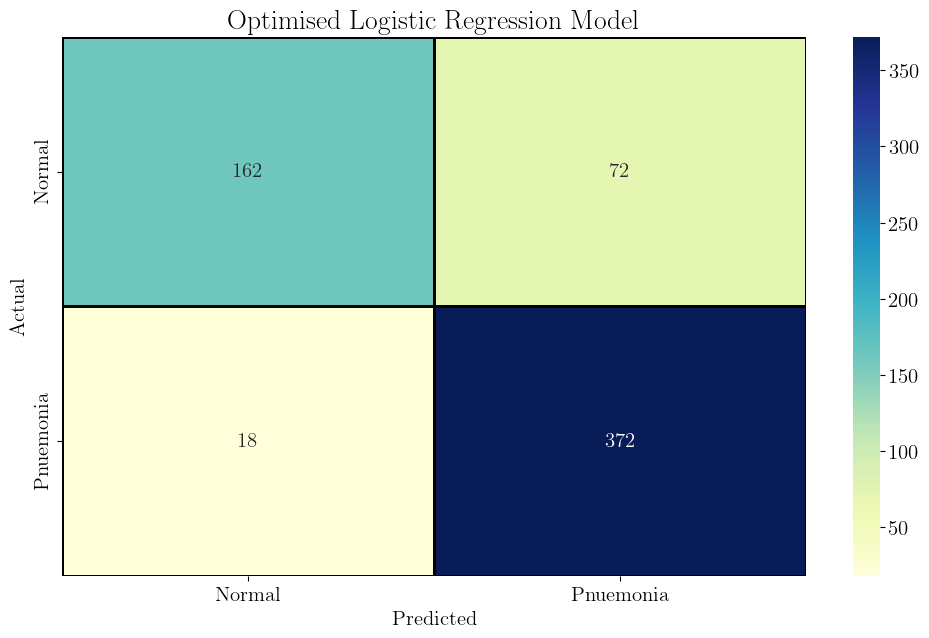

In [34]:
plot_confusion_matrix(best_lg.predict(X_test), y_test, 'Optimised Logistic Regression Model')

It is clear that using this pipeline, the best model (logistic regression) performs better than the one from the on-the-spot approach (SVM). The logistic regression may hit more false-possitives, however, it has greatly reduced the true-negatives (by 46).

The ideal model, therefore, for the chosen intelligent system will be the Logistic Regression using the proposed image preprocessing pipeline.

<a id="scrollTo=test"></a>
## Testing Best Intelligent System

Download an X-ray image from [medschool.co](https://medschool.co/) and test the best classic Ml model (Logistic Regression).

In [35]:
!wget https://medschool.co/images/detail/cxr/consolidation-rml.jpg

--2023-07-09 11:35:29--  https://medschool.co/images/detail/cxr/consolidation-rml.jpg
Resolving medschool.co (medschool.co)... 188.114.96.1, 188.114.97.1, 2606:4700:3108::ac42:2ad2, ...
Connecting to medschool.co (medschool.co)|188.114.96.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179120 (175K) [image/jpeg]
Saving to: ‘consolidation-rml.jpg’

consolidation-rml.j 100%[===================>] 174.92K   817KB/s    in 0.2s    

2023-07-09 11:35:30 (817 KB/s) - ‘consolidation-rml.jpg’ saved [179120/179120]



In [36]:
image = cv2.imread('/kaggle/working/consolidation-rml.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
features = extract_features(image)

pred = best_lg.predict([features])

if pred == 1:
    print('Patient is infected with pneumonia')
else:
    print('Patient is normal')

Patient is normal
